# Permutation Importance Documentation

This notebook demonstrates how to use`pymint` to compute predictor ranking using single-pass and multiple-pass permutation importance and plot the results. In the first set of examples, two tree-based models (random forest and gradient-boosting) and logistic regression from scikit-learn were trained on a portion of the road surface temperature data from Handler et al. (2020). The goal is to predict whether road surface temperatures will be above or below freezing (32 F) in the next hour. This dataset has 100 K examples with a class skew of 39%.

A second set of examples shows that the package is also compatable with regression-based problems as well. 
In those examples, we are using a single random forest trained on the California housing dataset available in scikit-learn. 

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [2]:
import pymint
import plotting_config 

### Loading the training data and pre-fit models for the classification problem

In [3]:
estimators, estimator_names = pymint.load_models()
X,y = pymint.load_data()

print(f'X Shape : {X.shape}')
print(f'y Skew : {y.mean()*100}%')

X Shape : (100000, 30)
y Skew : 39.173%


# InterpretToolkit

The primary component of `pymint` is the `InterpretToolkit`, which houses the computations and plotting for all the interpretability method contained within. 

To initialize `InterpretToolkit`, requires: 

* `models`, a pre-fit model object (or list thereof).
* `model_names`, the names of the models (for storing and plotting purposes)
* `examples` and `targets` (to evaluate the model on)
    * Can be `pandas.DataFrame` or `numpy.array`. If you use an `numpy.array`, however, then you must provide the feature names (`'feature_names'`) 

In [4]:
print(f'estimators : {estimators}\nestimator_names : {estimator_names}')

estimators : [RandomForestClassifier(min_samples_leaf=5, n_estimators=200, n_jobs=5), GradientBoostingClassifier(), LogisticRegression(C=1)]
estimator_names : ['Random Forest', 'Gradient Boosting', 'Logistic Regression']


In [5]:
explainer = pymint.InterpretToolkit(estimators,estimator_names=estimator_names, X=X, y=y,)

## Permutation Importance

Feature/predictor ranking is often a first step in model interpretability and a popular model-agnostic approach is the permutation importance method. In this method the data for each feature is permuted (shuffled) and the permuted feature causing the greatest loss of skill (based on some error metric) is deemed the most important (and each feature is ranked subsequently). This describes what is known as the single-pass permuation importance method (McGovern et al. 2019; Fig 1. @ https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance for an illustration). This method is appropriate for datasets with independent features (where little to no correlations exist between features). For datasets with physical or statistically dependent features, the more reliable method 
is the multi-pass permutation method (Lakshmanan et al. 2015, JOAT; see Fig.2 @ the above link) where the top feature remains permuted before assessing the second most important predictor, and so on for the third predictor and beyond.
By keeping features permuted, it ought to break the interfeature correlations. 

`pymint` uses a stripped-down version of the python package `PermutationImportance` to compute both the single and multipass permutation importance (see https://permutationimportance.readthedocs.io/en/latest/ for additional details). 

`pymint.calc_permutation_importance` requires the following args:
* `n_vars`, the number of predictor to compute for the multi-pass method.
* `evaluation_fn`, the error function used to assess loss of skill.
    * `mintpy` has 5 built-in error metrics for evaluating predictor importance: 
        * Area under the Curve (`'auc'`)
        * Area under the Precision-Recall Curve (`'aupdrc'`)
        * Normalized Area under the Performance Diagram Curve (`'norm_aupdc'`)
        * Brier Skill Score (`'bss'`)
        * Mean Square Error (`'mse'`) 
* `n_bootstrap`, number of times to repeat the calcuations for confidence intervals
* `subsample`, can be a float between 0-1 or an integer, which is interpreted as the percentage of examples or exact number of random samples to use, respectively. 
* `n_jobs`, number of processor to run the script on.
    * Could be the exact number or percentage of the total available to use (0-1) similar to subsample
* `verbose`, allows for a print out of the progress.
* `random_state`,  Pass an int to get reproducible results across function calls.
* `direction`, Whether features are progressively unpermuted (`'forward'`) or features are left permuted for second-, third-most important features (`'backward'`). The results are often not identical. 
   
__Note__: `evaluation_fn` can also be any user-defined function of the form 
`evaluation_fn(targets,predictions)` where a single value is returned. 
However, when using your own function, then you must also set the scoring strategy argument. If a metric is positively-oriented (a higher value is better), then set `scoring_strategy = "argmin_of_mean"` and if it is negatively-oriented-oriented (a lower value is better), then set `scoring_strategy = "argmax_of_mean"`. 


In this example, we want to know the top 10 predictors for all of our models. We are using normalized area under the precision-recall curve (NAUPDC; Flora et al. 2021) as the error metric. To produce confidence intervals, we are using 5 bootstrap iterations (kept small for illustration purposes, but should typically be 100-1000). The multipass permutation importance method can be computationally expensive for larger datasets or computing for a large number of top predictors. Thus, we've included a method to `pymint` to store the results for later use. The results are stored in `xarray.Dataset`s and saved as netcdf files. 



In [6]:
results = explainer.permutation_importance(
                                           n_vars=10, 
                                           evaluation_fn='norm_aupdc', 
                                               n_bootstrap=10, 
                                               subsample=0.25,
                                               n_jobs=8,
                                               verbose=True,
                                               random_state=42, 
                                               direction='backward'
                                              )

# Save the permutation importance results as a netcdf file using the bulit-in function within mintpy
explainer.save_results(fname='multipass_importance_naupdc.nc', data=results)

Starting on the important variable 1 out of 10...
Starting on the important variable 2 out of 10...
Starting on the important variable 3 out of 10...
Starting on the important variable 4 out of 10...
Starting on the important variable 5 out of 10...
Starting on the important variable 6 out of 10...
Starting on the important variable 7 out of 10...
Starting on the important variable 8 out of 10...
Starting on the important variable 9 out of 10...
Starting on the important variable 10 out of 10...
Starting on the important variable 1 out of 10...
Starting on the important variable 2 out of 10...
Starting on the important variable 3 out of 10...
Starting on the important variable 4 out of 10...
Starting on the important variable 5 out of 10...
Starting on the important variable 6 out of 10...
Starting on the important variable 7 out of 10...
Starting on the important variable 8 out of 10...
Starting on the important variable 9 out of 10...
Starting on the important variable 10 out of 10..

### Re-loading results 

`mintpy` can load and save its results and properly set up `InterpretToolkit` for plotting. To do so, we initialize an empty `InterpretToolkit` and call the `load_results` method. In addition to loading the saved data, the dataset is set as an attribute of InterpretToolkit, which makes using `mintpy` more streamlined. Though it is not demonstrated here, you can pass a list of filenames and the datasets are merged into one.  

In [7]:
explainer = pymint.InterpretToolkit()
# Load the results file; gets load as a class attribute 
results = explainer.load(fnames='multipass_importance_naupdc.nc')

<xarray.Dataset>
Dimensions:                                   (n_bootstrap: 10, n_vars_multipass: 10, n_vars_singlepass: 30)
Dimensions without coordinates: n_bootstrap, n_vars_multipass, n_vars_singlepass
Data variables:
    multipass_rankings__Random Forest         (n_vars_multipass) object ...
    multipass_scores__Random Forest           (n_vars_multipass, n_bootstrap) float64 ...
    singlepass_rankings__Random Forest        (n_vars_singlepass) object ...
    singlepass_scores__Random Forest          (n_vars_singlepass, n_bootstrap) float64 ...
    original_score__Random Forest             (n_bootstrap) float64 ...
    multipass_rankings__Gradient Boosting     (n_vars_multipass) object ...
    multipass_scores__Gradient Boosting       (n_vars_multipass, n_bootstrap) float64 ...
    singlepass_rankings__Gradient Boosting    (n_vars_singlepass) object ...
    singlepass_scores__Gradient Boosting      (n_vars_singlepass, n_bootstrap) float64 ...
    original_score__Gradient Boosting

## Plotting Single-Pass Permutation Importance 


The first iteration of the multi-pass permutation method is the single-pass method and is therefore saved by default.
To plot single-pass results, set `method="singlepass"`. The single-pass method ranks all features, so for readability, you can set `num_vars_to_plot` (default=15). Lastly, the metric used to compute the permutation importance is saved in the `xarray.Dataset` and is used by default to label the x-axis. However, if you want a "prettier" label, just set `metrics_used`.  

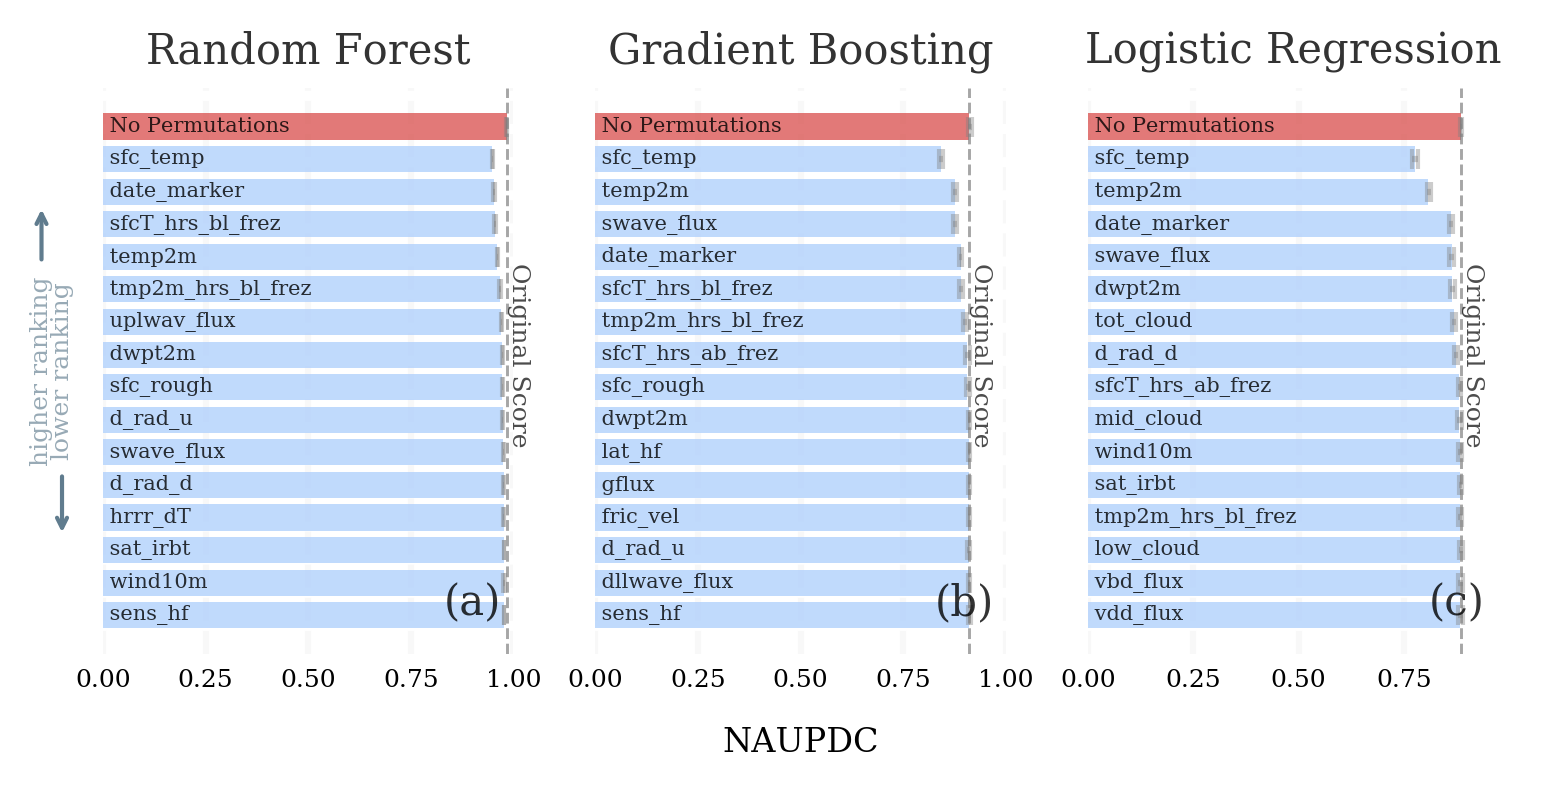

In [8]:
fig = explainer.plot_importance(data=results, method='singlepass', num_vars_to_plot=15, metrics_used='NAUPDC')

### Changing the facecolor

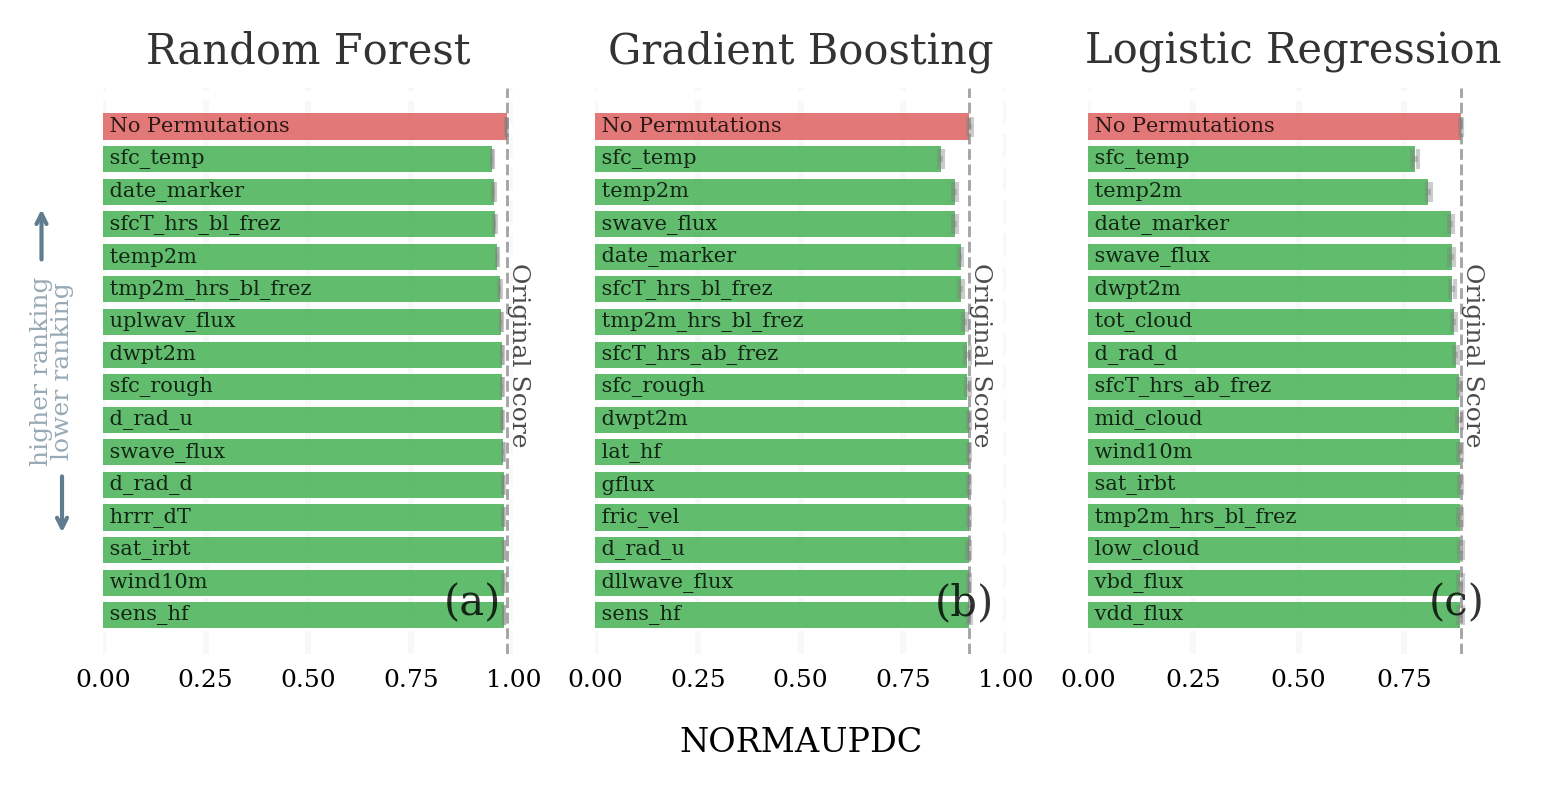

In [9]:
fig = explainer.plot_importance(
                                data=results,
                                method='singlepass', 
                                num_vars_to_plot=15,
                                feature_colors = 'xkcd:medium green'
                                    )

## Plotting Multi-Pass Permutation Importance 

To plot the multi-pass results, set `multipass=True`. 


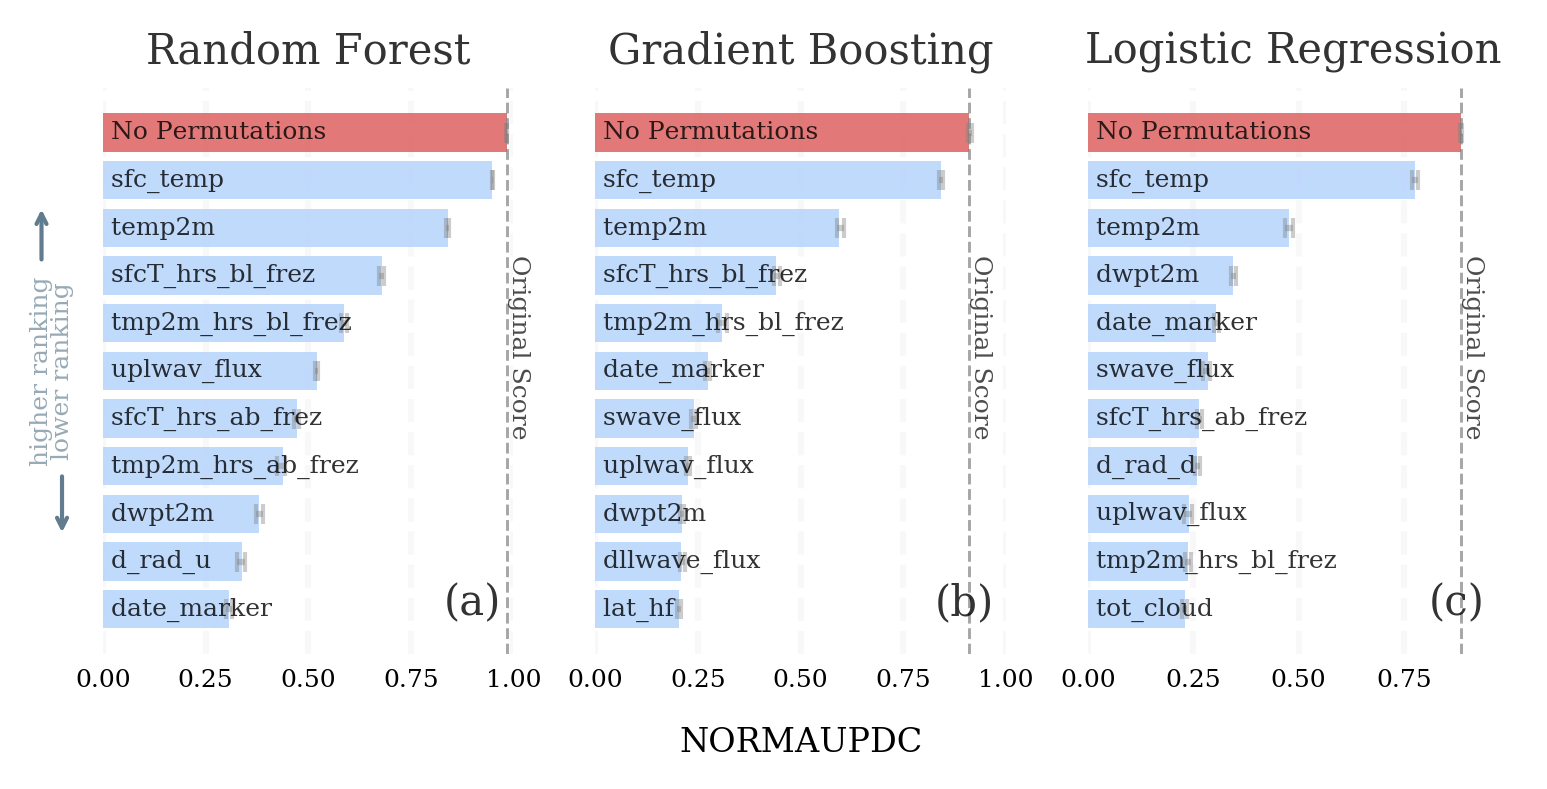

In [10]:
fig = explainer.plot_importance(data=results, method='multipass', num_vars_to_plot=10,)

## Plotting Permutation Importance (with Color Coding and Readable Predictor Names)

To personalize your plots, you can pass a dict `display_feature_names`, which should map the feature names with a prettier, more interpretable name. Additionally, you can color code your predictors with `feature_colors`, which maps the stored feature names to a color (see https://i.stack.imgur.com/nCk6u.jpg for a extension map of named colors in python). To see our example of `display_feature_names` and `feature_colors`, look in `plotting_config.py`. 

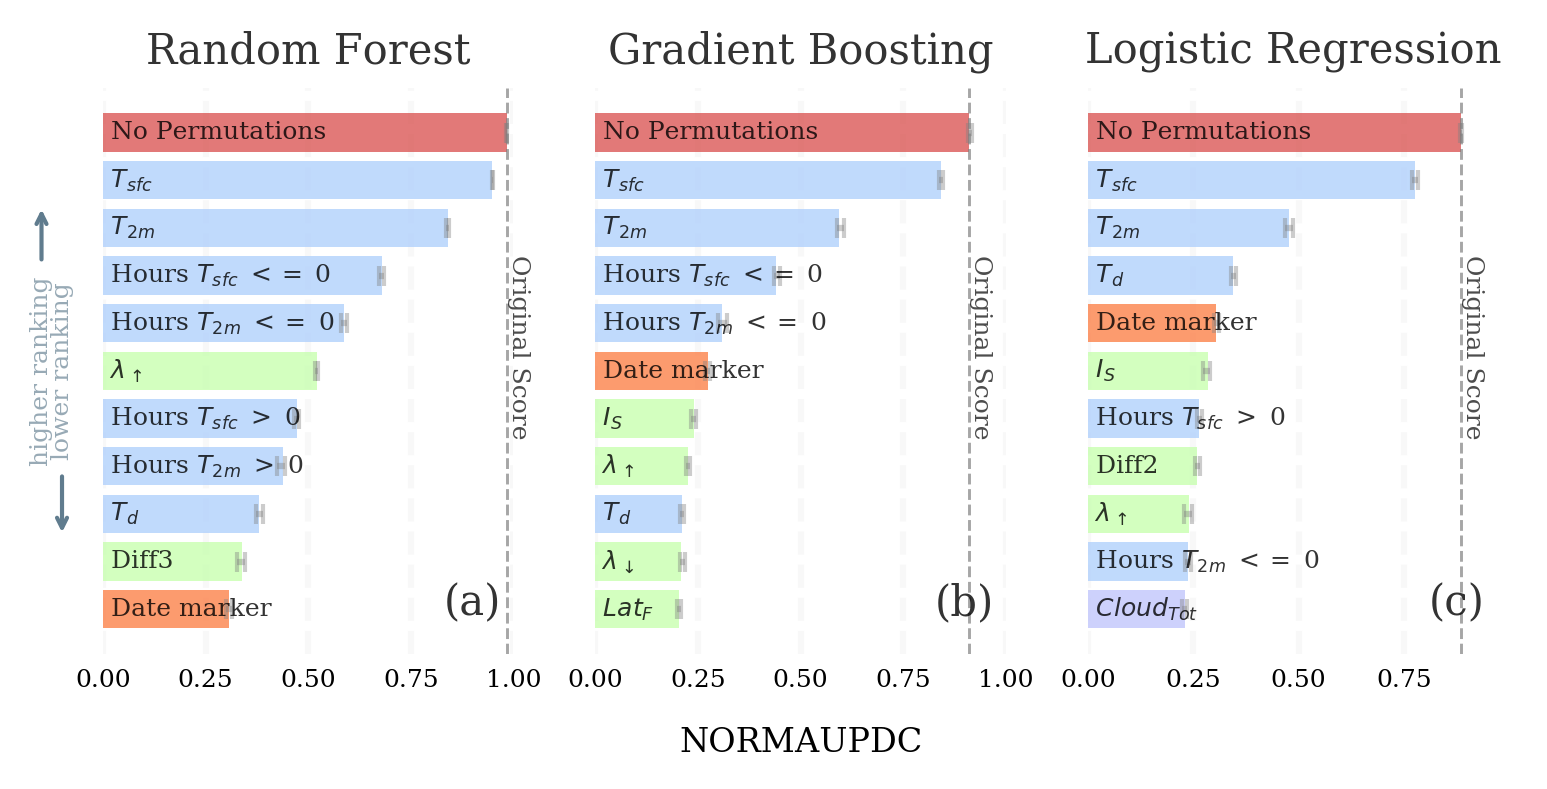

In [11]:
fig = explainer.plot_importance(data=results,
                                    method='multipass', 
                                    display_feature_names=plotting_config.display_feature_names,
                                    feature_colors=plotting_config.color_dict,
                                   )

## Annotating Correlated Features

One limitation of the permutation importance method is the assumption that features are independent. If there are strong statistical or physical correlations between features, then the marginal-based shuffling of values can create unphysical/unrealistic examples, which will force the ML model to extrapolate. Correlated features can also distort the feature rankings. Therefore, there is a argument in `plot_importance` where we can annotate if any of the feature shown have a strong linear correlation. To use this, set `plot_correlated_features=True`. 


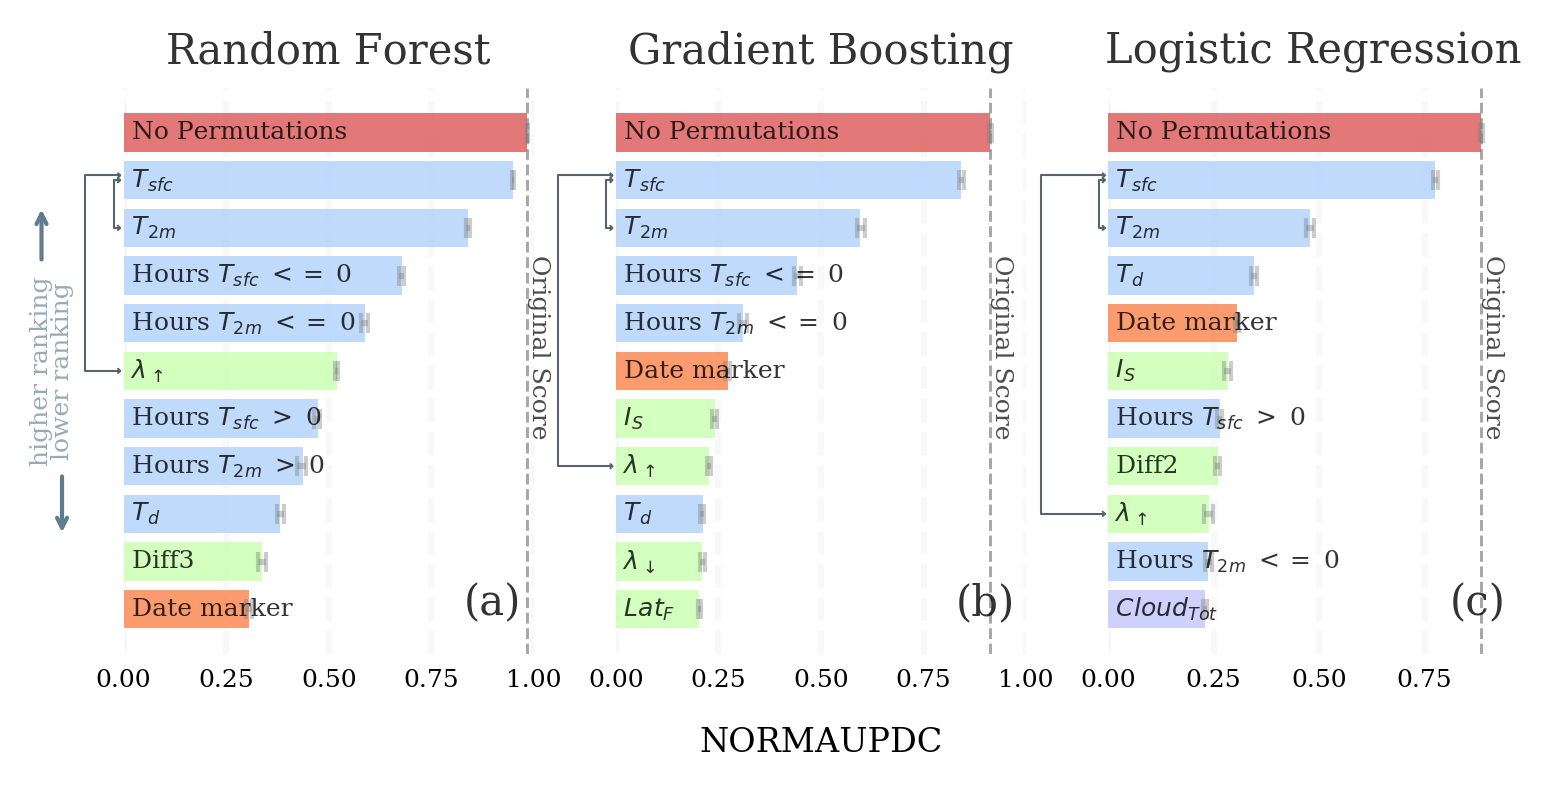

In [12]:
explainer = pymint.InterpretToolkit(estimators,estimator_names=estimator_names, X=X, y=y,)
fig = explainer.plot_importance(data=results, 
                                    method='multipass', 
                                    display_feature_names=plotting_config.display_feature_names,
                                    feature_colors=plotting_config.color_dict,
                                    plot_correlated_features=True,
                                   )

As we can see, the random forest (panel a) has multiple correlated pairs in the top 10 features. 

### Plotting Permutation Importance for Multiple Metrics 

The feature ranking can be sensitive to the error metric used. We can compute the permutation importance again, but this time with Area under the Precision-Recall Curve (AUPRC; also known as Area under the Performance Diagram for meteorologists). To plot results for both metrics, set `result_dict` to a list of both results. Also, to label each row, set the argument `ylabels`. In our case, We've set `ylabels = ['AUC', 'AUPRC']`.

In [13]:
explainer = pymint.InterpretToolkit(estimators,estimator_names=estimator_names, X=X, y=y,)
auc_results = explainer.permutation_importance(
                                               n_vars=10, 
                                               evaluation_fn='auc', 
                                               n_bootstrap=5, 
                                               subsample=0.01,
                                               n_jobs=8,
                                               random_state=42, 
                                              )
explainer.save(fname='multipass_importance_auc.nc', data=auc_results)

<xarray.Dataset>
Dimensions:                                   (n_bootstrap: 5, n_vars_multipass: 10, n_vars_singlepass: 30)
Dimensions without coordinates: n_bootstrap, n_vars_multipass, n_vars_singlepass
Data variables:
    multipass_rankings__Random Forest         (n_vars_multipass) object ...
    multipass_scores__Random Forest           (n_vars_multipass, n_bootstrap) float64 ...
    singlepass_rankings__Random Forest        (n_vars_singlepass) object ...
    singlepass_scores__Random Forest          (n_vars_singlepass, n_bootstrap) float64 ...
    original_score__Random Forest             (n_bootstrap) float64 ...
    multipass_rankings__Gradient Boosting     (n_vars_multipass) object ...
    multipass_scores__Gradient Boosting       (n_vars_multipass, n_bootstrap) float64 ...
    singlepass_rankings__Gradient Boosting    (n_vars_singlepass) object ...
    singlepass_scores__Gradient Boosting      (n_vars_singlepass, n_bootstrap) float64 ...
    original_score__Gradient Boosting 

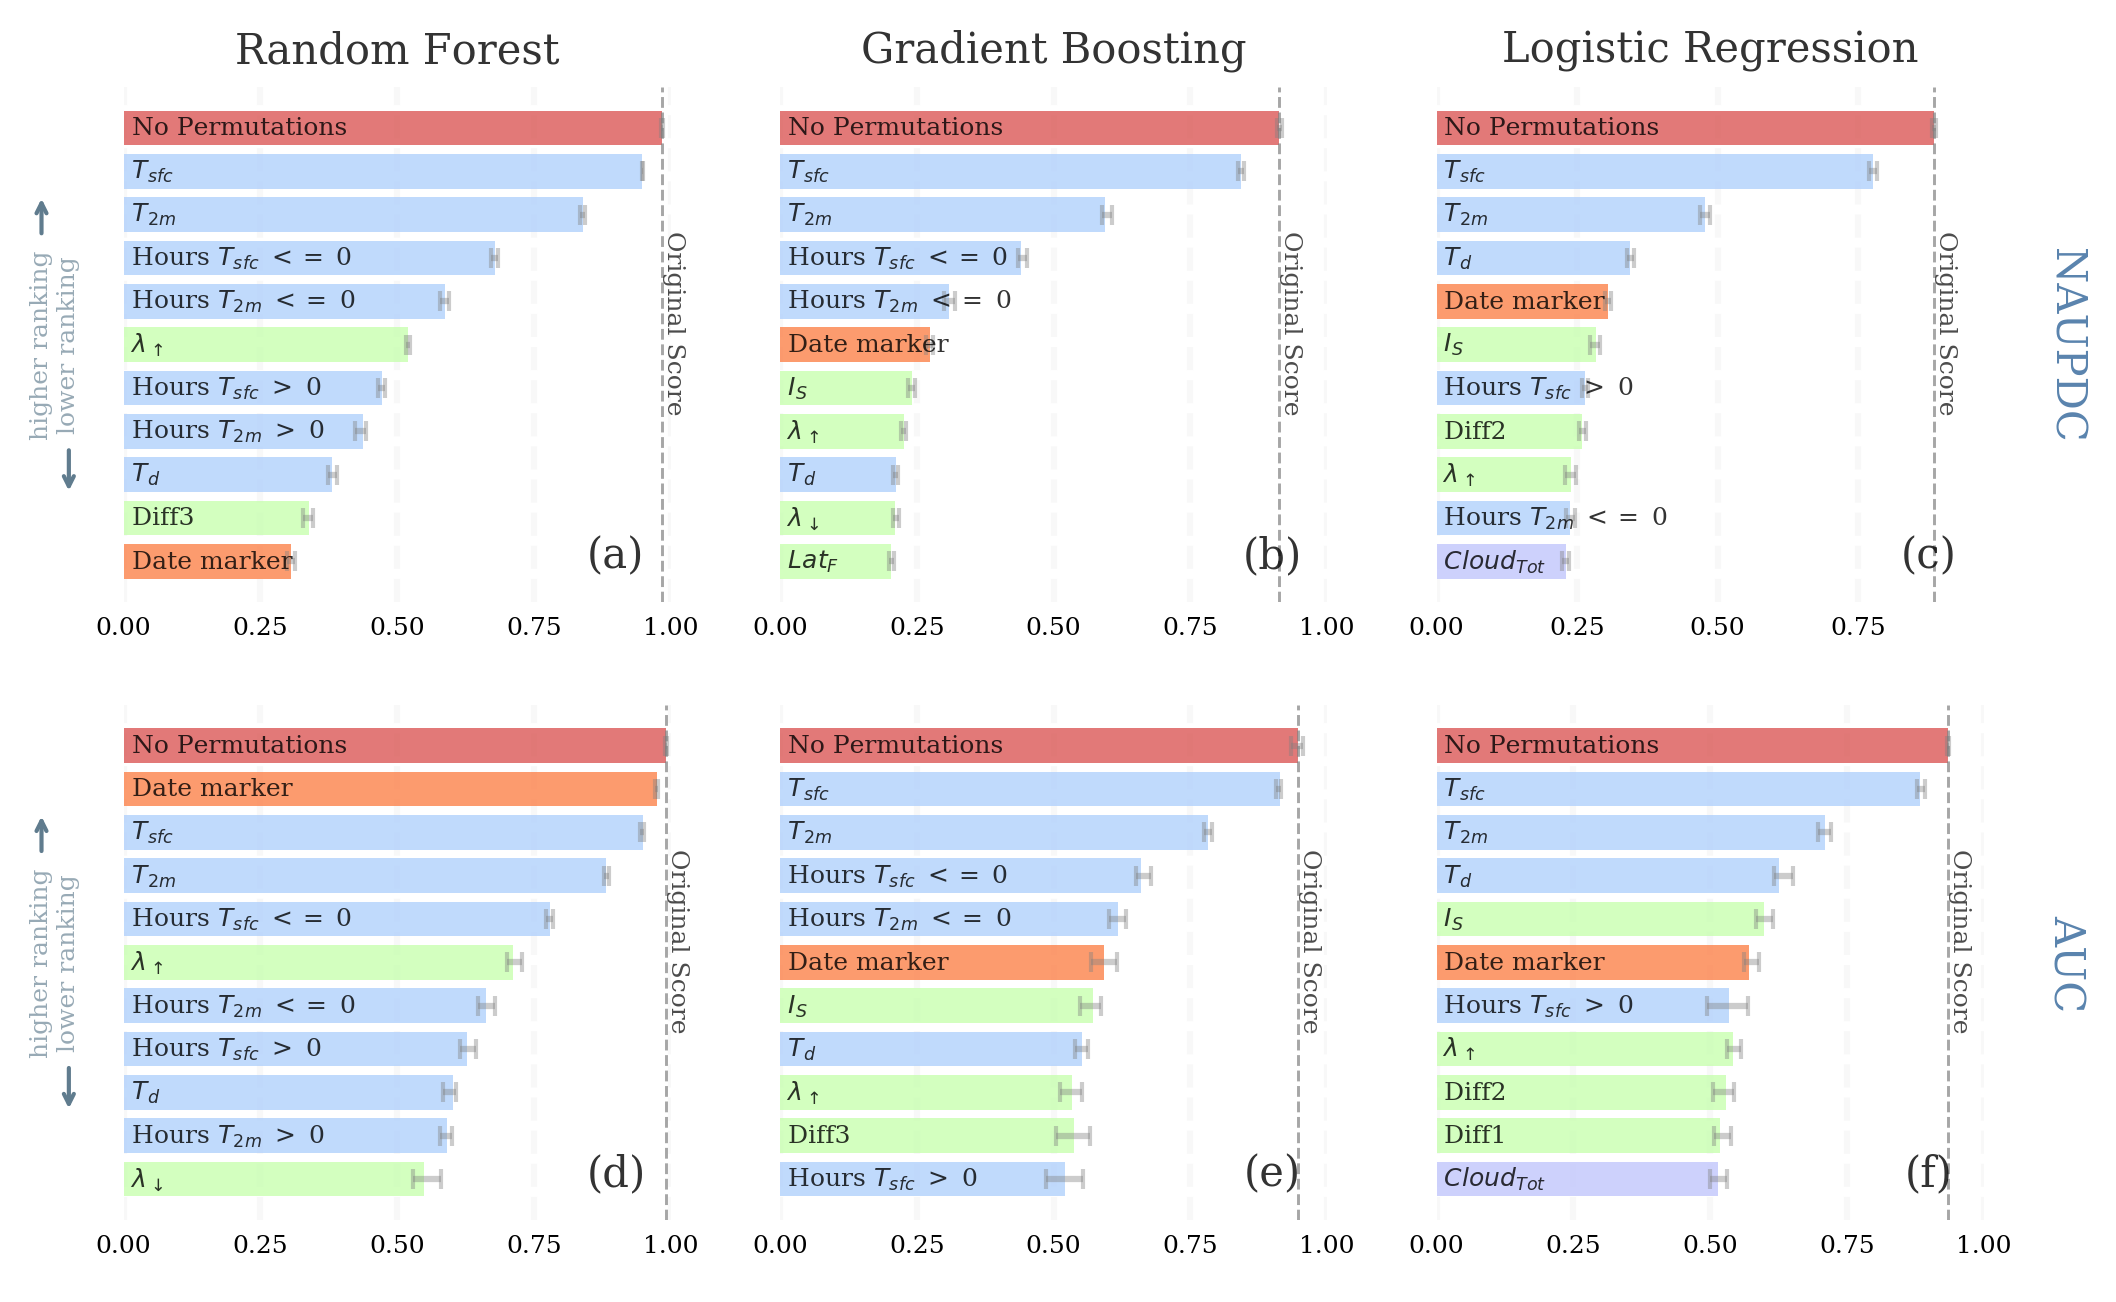

In [14]:
auc_results = explainer.load(fnames='multipass_importance_auc.nc')
fig = explainer.plot_importance(
                                 data = [results, auc_results],
                                 method='multipass',
                                 display_feature_names=plotting_config.display_feature_names,
                                 feature_colors=plotting_config.color_dict,
                                 ylabels = ['NAUPDC', 'AUC'],
                                 figsize = (8,5), 
                                 hspace = 0.2
                                   )

There are some differences, but overall the feature ranking are roughly similar. This bolsters our confidence in the feature ranking and helps triangulate the most important predictors. 

## Comparing Forward vs. Backward Multi-pass Permutation Importance

In [15]:
forward_results = explainer.permutation_importance(
                                               n_vars=10, 
                                               evaluation_fn='norm_aupdc', 
                                               n_bootstrap=10, 
                                               subsample=0.25,
                                               n_jobs=8,
                                               verbose=True,
                                                random_state=42, 
                                               direction='forward'
                                              )

# Save the permutation importance results as a netcdf file using the bulit-in function within mintpy
explainer.save(fname='multipass_importance_forward_naupdc.nc', data=results)

Starting on the important variable 1 out of 10...
Starting on the important variable 2 out of 10...
Starting on the important variable 3 out of 10...
Starting on the important variable 4 out of 10...
Starting on the important variable 5 out of 10...
Starting on the important variable 6 out of 10...
Starting on the important variable 7 out of 10...
Starting on the important variable 8 out of 10...
Starting on the important variable 9 out of 10...
Starting on the important variable 10 out of 10...
Starting on the important variable 1 out of 10...
Starting on the important variable 2 out of 10...
Starting on the important variable 3 out of 10...
Starting on the important variable 4 out of 10...
Starting on the important variable 5 out of 10...
Starting on the important variable 6 out of 10...
Starting on the important variable 7 out of 10...
Starting on the important variable 8 out of 10...
Starting on the important variable 9 out of 10...
Starting on the important variable 10 out of 10..

<xarray.Dataset>
Dimensions:                                   (n_bootstrap: 10, n_vars_multipass: 10, n_vars_singlepass: 30)
Dimensions without coordinates: n_bootstrap, n_vars_multipass, n_vars_singlepass
Data variables:
    multipass_rankings__Random Forest         (n_vars_multipass) object ...
    multipass_scores__Random Forest           (n_vars_multipass, n_bootstrap) float64 ...
    singlepass_rankings__Random Forest        (n_vars_singlepass) object ...
    singlepass_scores__Random Forest          (n_vars_singlepass, n_bootstrap) float64 ...
    original_score__Random Forest             (n_bootstrap) float64 ...
    multipass_rankings__Gradient Boosting     (n_vars_multipass) object ...
    multipass_scores__Gradient Boosting       (n_vars_multipass, n_bootstrap) float64 ...
    singlepass_rankings__Gradient Boosting    (n_vars_singlepass) object ...
    singlepass_scores__Gradient Boosting      (n_vars_singlepass, n_bootstrap) float64 ...
    original_score__Gradient Boosting

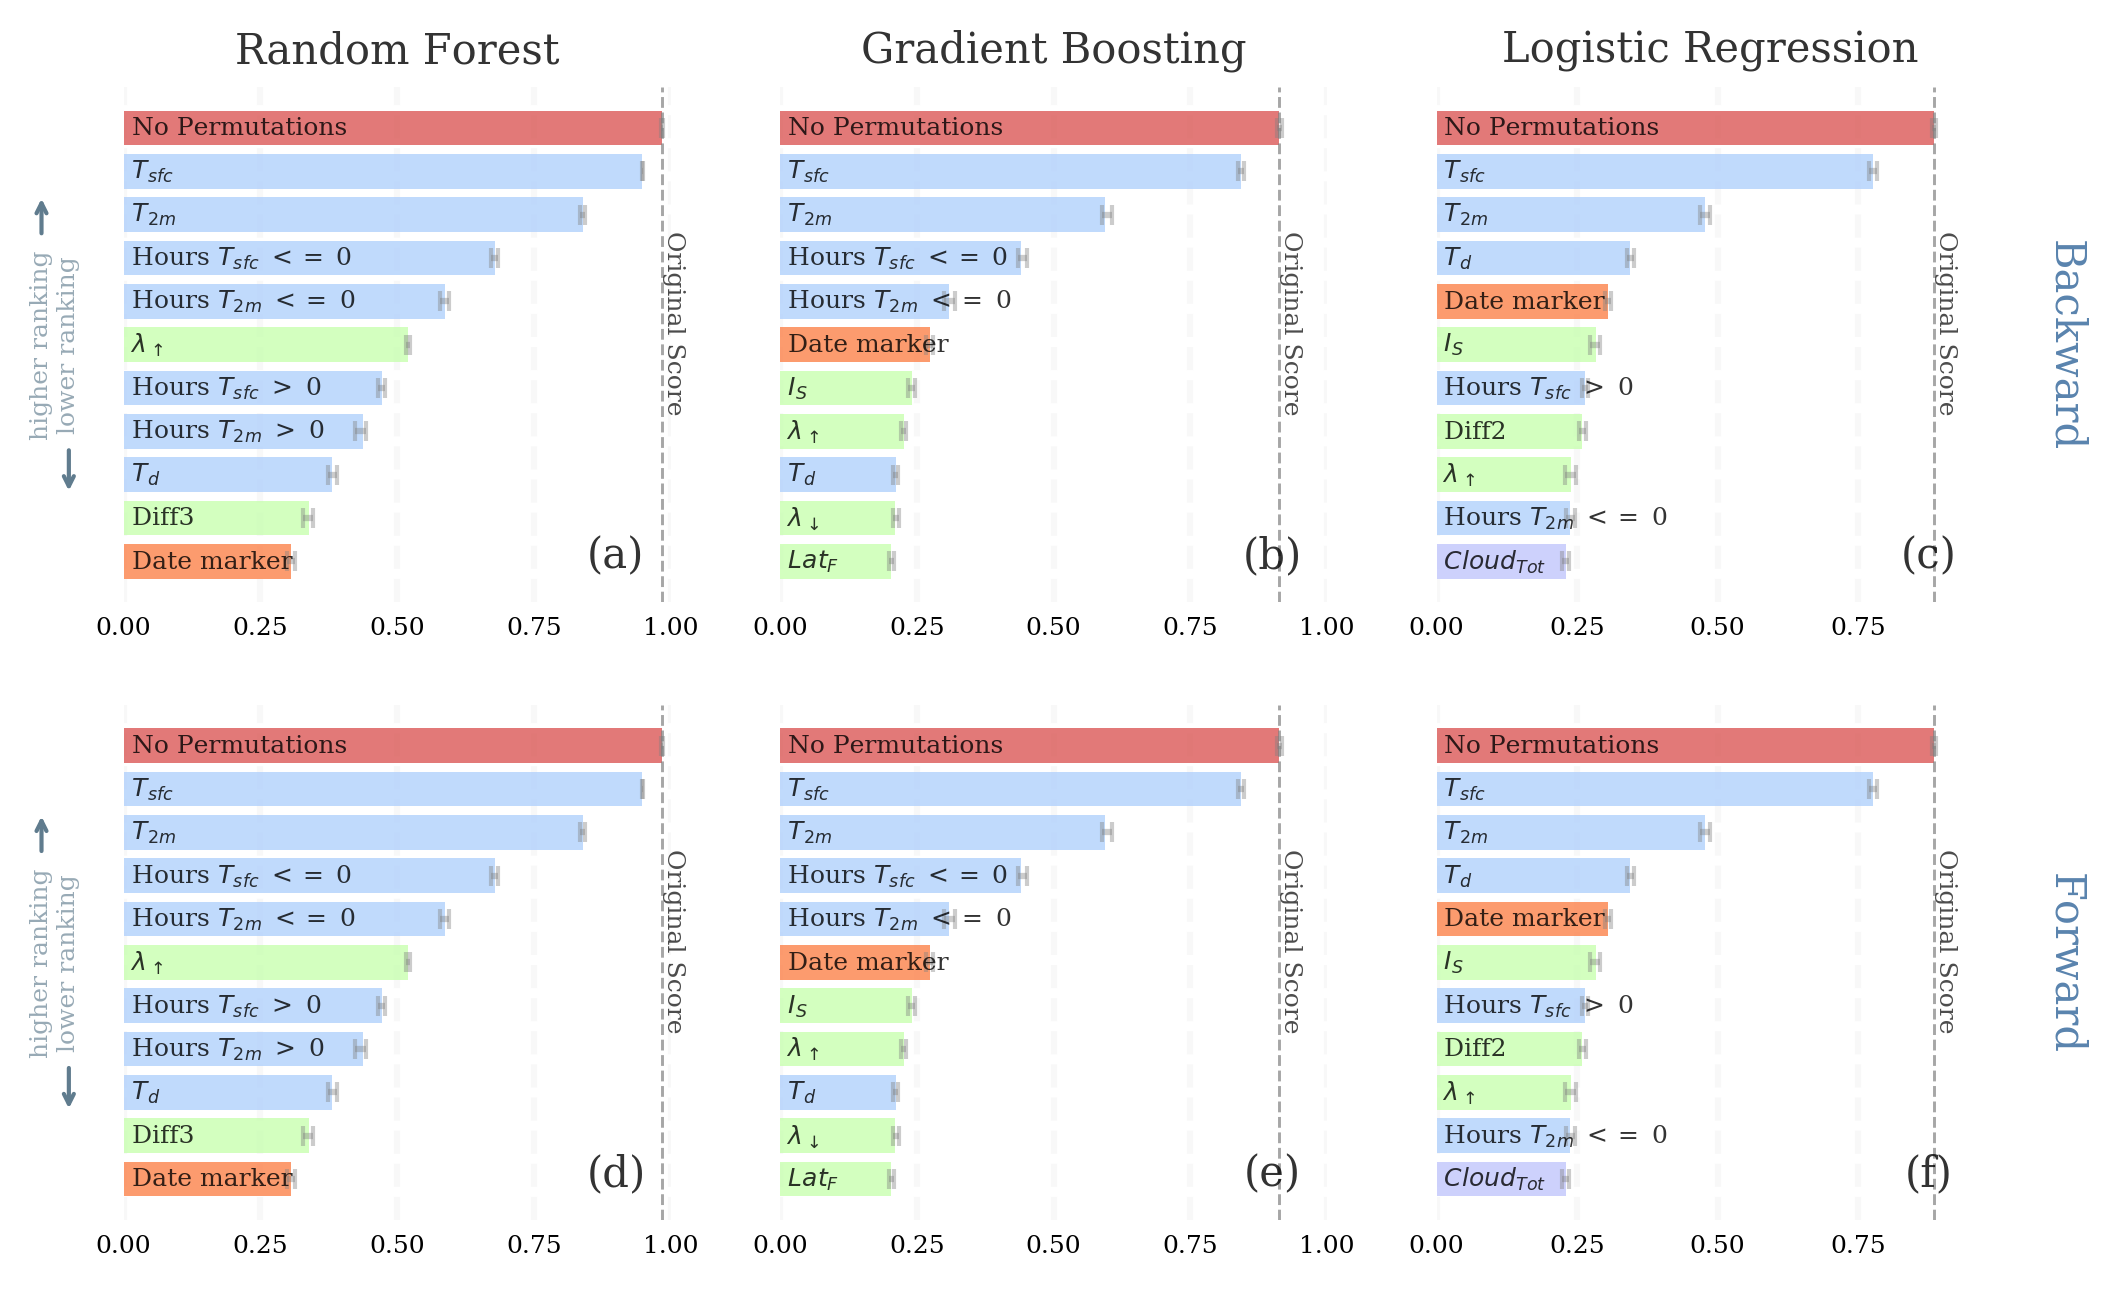

In [16]:
forward_results = explainer.load_results(fnames='multipass_importance_forward_naupdc.nc')
fig = explainer.plot_importance(
                                    data = [results, forward_results],
                                    method='multipass',
                                    display_feature_names=plotting_config.display_feature_names,
                                    feature_colors=plotting_config.color_dict,
                                    ylabels = ['Backward', 'Forward'],
                                    figsize = (8,5), 
                                    hspace = 0.2
                                   )

## Permutation Importance for Regression Problems

In [17]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [18]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
clf = RandomForestRegressor()
clf.fit(X,y)

RandomForestRegressor()

In [19]:
explainer = pymint.InterpretToolkit(clf,'Random Forest',X=X,y=y,feature_names = feature_names)
reg_results = explainer.permutation_importance(
                                               n_vars=8, 
                                               evaluation_fn='mse', 
                                               n_bootstrap=10, 
                                               subsample=0.25,
                                               n_jobs=8,
                                               verbose=True,
                                               random_state=42, 
                                              )

Starting on the important variable 1 out of 8...
Starting on the important variable 2 out of 8...
Starting on the important variable 3 out of 8...
Starting on the important variable 4 out of 8...
Starting on the important variable 5 out of 8...
Starting on the important variable 6 out of 8...
Starting on the important variable 7 out of 8...
Starting on the important variable 8 out of 8...


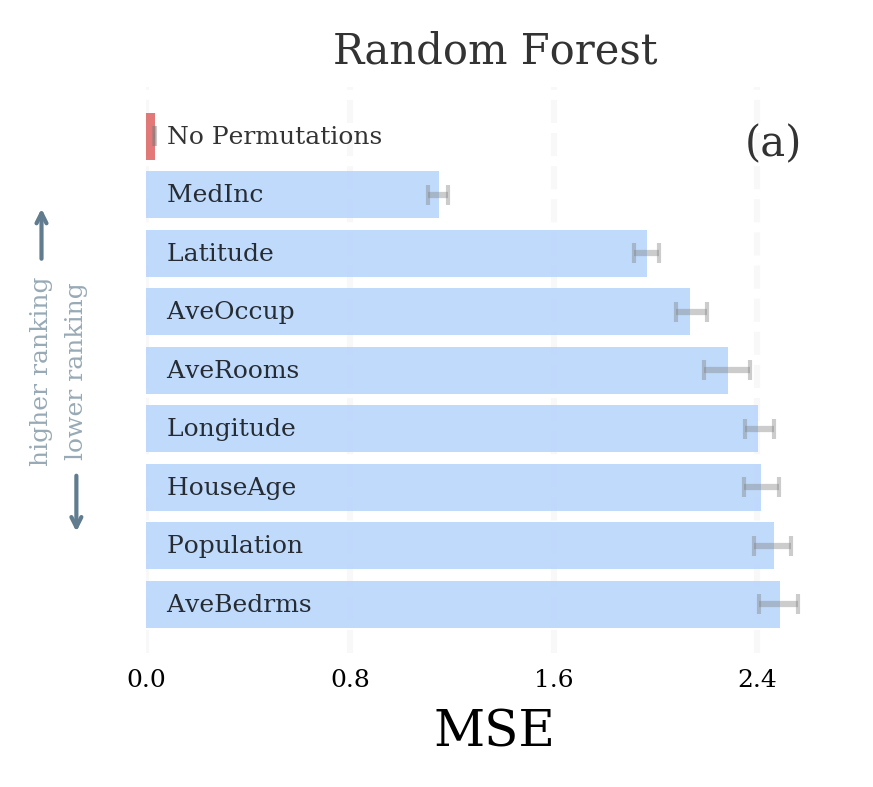

In [20]:
fig = explainer.plot_importance(data=reg_results, method='multipass', num_vars_to_plot=8)

References: 

Handler, S. L., H. D. Reeves, and A. McGovern, Development of a Probabilistic Subfreezing Road Temperature Nowcast and Forecast Using Machine Learning. Wea. Forecasting, doi: https://doi.org/10.1175/WAF-D-19-0159.1

McGovern, A., R. Lagerquist, D. John Gagne, G. E. Jergensen, K. L. Elmore, C. R. Homeyer, and T. Smith, 2019: Making the Black Box More Transparent: Understanding the Physical Implications of Machine Learning. Bull. Amer. Meteor. Soc., 100, 2175–2199, https://doi.org/10.1175/BAMS-D-18-0195.1.